In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [3]:
dataset = 'tij_InVS15'
beta = 0.4
Delta_T = 400
k = 5
phi = 0.5

In [8]:
src, dst, ts = [], [], []
G = nx.Graph()

with open(f'../data/{dataset}.txt', 'r') as f:
    for line in f:
        line = list(map(int, line.strip().split('\t')))
        src.append(line[0])
        dst.append(line[1])
        ts.append(line[2])
        G.add_node(line[0], is_infected=False)
        G.add_node(line[1], is_infected=False)
        G.add_edge(line[0], line[1], timestamp=line[2])

src, dst, ts = np.array(src), np.array(dst), np.array(ts) # ts is given sorted

In [9]:
rng = np.random.RandomState(1)

node_influences = []

# for each node in the graph
for node in G.nodes:
    # pick a random t_0 and infect the node
    if not np.any(src == node):
        node_influences.append(0)
        continue
    t_0 = np.min(ts[src == node])
    G.nodes[node]['is_infected'] = True

    # for every timestep in (t_0, t_0 + Delta_T)
    for t in range(t_0 + 1, t_0 + Delta_T):
        if t not in ts:
            continue
        # for every node in the graph
        for n, nbrs in G.adj.items():
            # if the node is infected
            if G.nodes[n]['is_infected']:
                # get its neighbors at that timestamp
                for nbr, eattr in nbrs.items():
                    if eattr['timestamp'] == t:
                        # infect them with probability b
                        G.nodes[nbr]['is_infected'] = True if rng.uniform() <= beta else False

    # node influence
    node_influences.append(len([n for n in G.nodes if G.nodes[n]['is_infected']]) / len(G.nodes))

    # reset graph
    for n in G.nodes:
        G.nodes[n]['is_infected'] = False

node_influences = np.array(node_influences)

In [ ]:
####### labels #######
labels = [
    'Number of union of contacts in [t_0, t_0 + Delta_T]',
    'Closeness Centrality',
    'Wiener Indices',
    'Betweenness Centrality',
    'Subgraph Centrality',
    'VoteRank',
    'Degree',
    'Degree Assortativity Coefficient',
    'Harmonic Centrality',
    'Local Reaching Centrality',
    # 'Eigenvector Centrality'
]

metrics = [[] for _ in labels]
for node in G.nodes:
    if not np.any(src == node):
        for i in range(len(metrics)):
            metrics[i].append(0)
        continue
    # get the index of the first time that node appears
    start_idx = np.min(np.arange(len(src))[src == node])
    t_0 = ts[start_idx]

    subgraph = nx.Graph()  # subgraph in (t_0, t_0 + Delta_T)
    for t in range(start_idx, start_idx + int(phi * Delta_T)):
        if t < len(src):
            subgraph.add_edge(src[t], dst[t])

    ####### metrics #######
    metrics[0].append(len(nx.single_source_shortest_path(subgraph, node, cutoff=k)))
    metrics[1].append(nx.closeness_centrality(subgraph, node))
    metrics[2].append(nx.wiener_index(subgraph))
    metrics[3].append(nx.betweenness_centrality(subgraph)[node])
    metrics[4].append(nx.subgraph_centrality(subgraph)[node])
    metrics[5].append(np.argmax(nx.voterank(subgraph)))
    metrics[6].append(subgraph.degree[node])
    metrics[7].append(nx.degree_assortativity_coefficient(subgraph))
    metrics[8].append(nx.harmonic_centrality(subgraph)[node])
    metrics[9].append(nx.local_reaching_centrality(subgraph, node))
    # metrics[10].append(nx.eigenvector_centrality(subgraph)[node])

for i, m in enumerate(metrics):
    m = np.array(m)
    m = np.abs(m)
    ma = np.max(m[m != np.inf])
    m = m / ma # scale it to 0-1
    m[m == np.inf] = 1
    metrics[i] = m

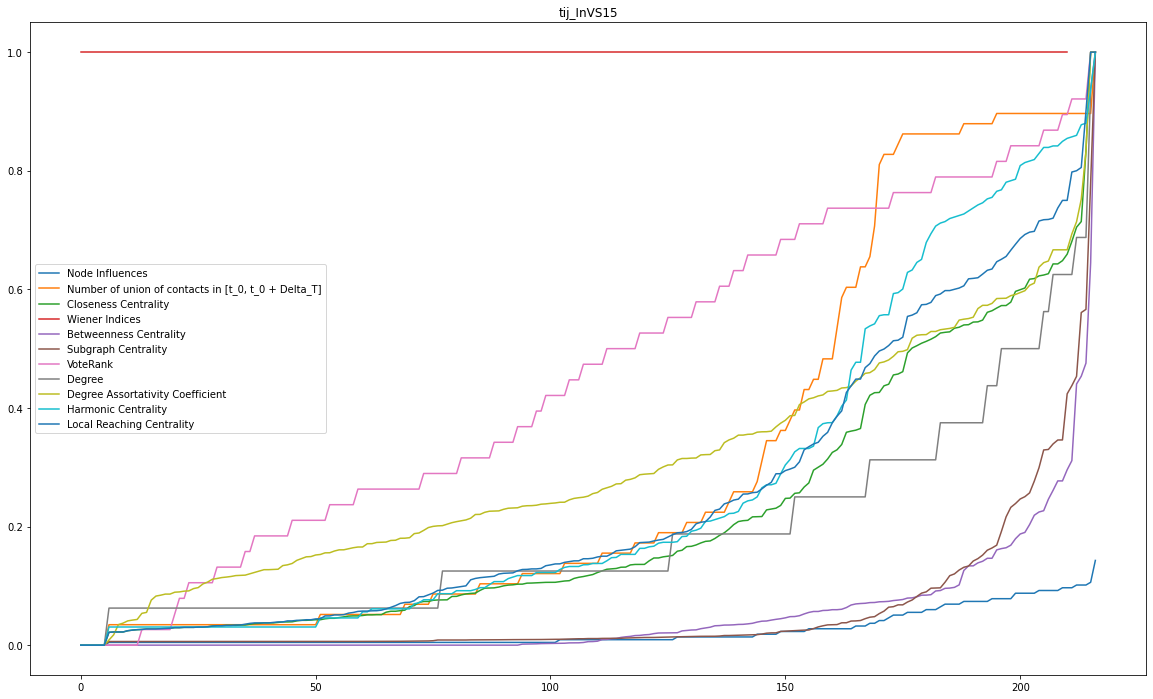

In [11]:
# Plot

x = np.arange(len(node_influences))
# sort to compare cumulatively
y = np.sort(node_influences)
for i, m in enumerate(metrics):
    metrics[i] = np.sort(m)

fig, ax1 = plt.subplots(figsize=(20, 12))
ax1.plot(x, y, label='Node Influences')
for i, m in enumerate(metrics):
    ax1.plot(x, m, label=labels[i])
plt.title(dataset)
plt.legend()
plt.savefig(f'{dataset}.png')

Conclusions

Useful metrics that seem to model closely to the node influences, apart from Num. of union of contacts:

|dataset      | n_edges | beta |Delta_T|duration|k    |phi  |best metrics|
| ----------- | ------- | ---- | ----- | ------ | --- | --- | ---------- |
| ht09        |  20818  | 0.8  | 1000  | 27s    | 5   | 0.5 |  Closeness Centrality, Local Reaching Centrality, maybe Harmonic Centrality too     |
| infectious  |  17298  | 0.6  | 500   | 67s    | 5   | 0.5 |  Eigenvalue Centrality does not converge, so removed. Definitely Closeness Centrality is good, Harmonic Centr., Degree Assort. Coeff., Local Reaching Centrality, Degree good too. |
| SFHH        | 70261   | 0.4  | 400   |  69s   | 5   | 0.5 | Eigen. not converging, removed. Local Reaching Centrality, Closeness Centrality great, Harmonic/Voterank and Degree good. |    
| tij_lnVS15  | 78249   | 0.4  | 400   |  14s   | 5   | 0.5 | Eigen. again not conv., removed. Closeness/Harmonic Centralities and Degree great, Local Reaching Centrality very bad this time. |
